## NLP Project on Quora Duplicate Questions Pair Identification

   #### Problem Statement and Objective
   
   In the online world, people tend to ask the same questions in various ways, especially on platforms like Quora. This         creates confusion for readers and makes it challenging for businesses to provide consistent answers. The goal of this         article is to explore how NLP (Natural Language Processing) and machine learning can be used to develop a system that         identifies and responds to similar queries. Businesses are seeking a solution to save time and effort by automating the       process of recognizing and answering similar questions across different expressions.

#### Dataset Description
The dataset chosen for this NLP project is from a renowned Kaggle competition hosted by Quora, offering a prize of $25,000. The dataset consists of five columns, featuring two columns with distinct questions, two columns containing the corresponding question IDs, and a final column indicating the target variable. The target variable is binary, with a value of 1 denoting duplicate questions and 0 indicating non-duplicate ones.

link: https://www.kaggle.com/c/quora-question-pairs/data?select=train.csv.zip

### Project Development Overflow
Basic Data Analysis --->
Feature Engineering --->
Model Development   --->
Optimize the model to increase performance

# Basic Data Analysis

#### 1.Load the Dataset

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/quora_train.csv')
df.shape

(404290, 6)

In [3]:
# the dataset is too large for our RAM. So we take a sample dataset
df_pos = df[df['is_duplicate']==1]
df_neg = df[df['is_duplicate']==0]
df = pd.concat([df_pos[:7500], df_neg[:7500]], axis=0)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import pandas as pd

def text_processing_quora_separate(data):
    from bs4 import BeautifulSoup
    import re
    from nltk.corpus import stopwords
    from tqdm import tqdm
    from nltk.stem import PorterStemmer

    def decontracted(phrase):
        # specific
        phrase = re.sub(r'<br /><br />', ' ', phrase)
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r'"', " ", phrase)
        return phrase

    stopwords_set = set(stopwords.words("english"))

    preprocessed_question1 = []
    preprocessed_question2 = []
    porter = PorterStemmer()

    # tqdm is for printing the status bar
    for row in tqdm(data.itertuples(), total=len(data), desc="Processing Quora Data"):
        q1 = row.question1
        q2 = row.question2

        # Process question1
        processed_q1 = re.sub(r"http\S+", "", q1)
        processed_q1 = decontracted(processed_q1)
        processed_q1 = re.sub("\S*\d\S*", "", processed_q1).strip()
        processed_q1 = ' '.join(word.lower() for word in processed_q1.split() if word not in stopwords_set)
        stemmed_words_q1 = [porter.stem(word) for word in processed_q1.split()]
        preprocessed_question1.append(' '.join(stemmed_words_q1))

        # Process question2
        processed_q2 = re.sub(r"http\S+", "", q2)
        processed_q2 = decontracted(processed_q2)
        processed_q2 = re.sub("\S*\d\S*", "", processed_q2).strip()
        processed_q2 = ' '.join(word.lower() for word in processed_q2.split() if word not in stopwords_set)
        stemmed_words_q2 = [porter.stem(word) for word in processed_q2.split()]
        preprocessed_question2.append(' '.join(stemmed_words_q2))

    return preprocessed_question1, preprocessed_question2



# Preprocess the questions separately
preprocessed_q1, preprocessed_q2 = text_processing_quora_separate(df)

# Replace the original columns with the preprocessed versions
df['question1'] = preprocessed_q1
df['question2'] = preprocessed_q2

df.head()

Processing Quora Data: 100%|██████████| 15000/15000 [00:08<00:00, 1672.38it/s]


,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,astrology: i capricorn sun cap moon cap rising...,"i tripl capricorn (sun, moon ascend capricorn)...",1
7,7,15,16,how i good geologist?,what i great geologist?,1
11,11,23,24,how i read find youtub comments?,how i see youtub comments?,1
12,12,25,26,what make physic easi learn?,how make physic easi learn?,1
13,13,27,28,what first sexual experi like?,what first sexual experience?,1


#### 2.Check for Null Values

In [6]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


so there are no null values in the dataset

#### 3.Check Duplicates Distribution

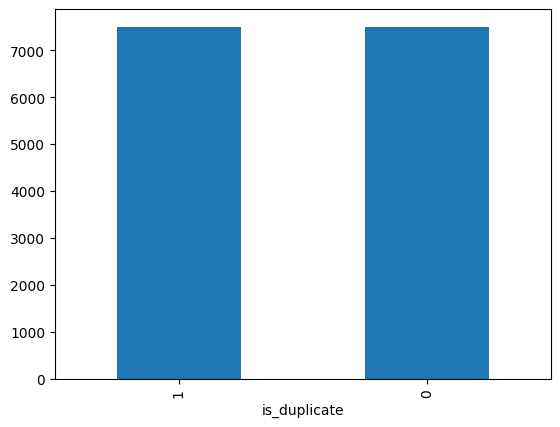

In [7]:
df['is_duplicate'].value_counts().plot(kind='bar');

#### 4.Check for Repeated Questions

Number of unique questions 28152
Number of questions getting repeated 1474


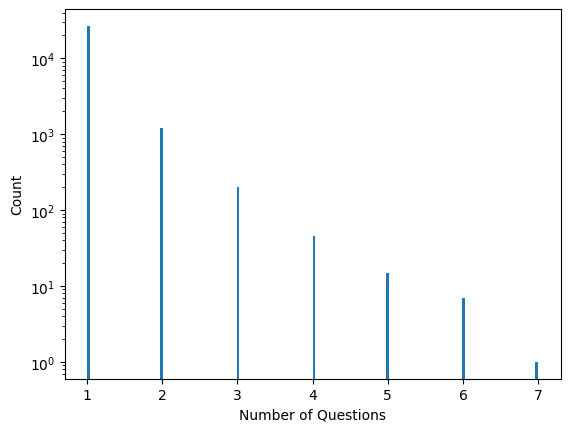

In [8]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.xlabel('Number of Questions')
plt.ylabel('Count')
plt.show()

# Feature Engineering

Feature engineering is a fundamental technique that involves adding new features to a dataset, aiming to enhance the prediction of output variables and improve model accuracy. Crucial features have a direct impact on the model's performance. Feature engineering encompasses various processes such as transformation, scaling, feature extraction, feature encoding, and exploratory data analysis (EDA).

In our case, we plan to augment our existing dataset by introducing seven additional features. Leveraging the bag of words model for questions 1 and 2, we will generate distinct features. These newly created features will undergo exploratory data analysis before being incorporated into the machine learning model, contributing to a more robust predictive framework.

#### 1. Question Length

In [9]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

#### 2. Number of Words

In [10]:
df['q1_word_count'] = df['question1'].str.split().str.len()
df['q2_word_count'] = df['question2'].str.split().str.len()
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count
5,5,11,12,astrology: i capricorn sun cap moon cap rising...,"i tripl capricorn (sun, moon ascend capricorn)...",1,61,59,10,10
7,7,15,16,how i good geologist?,what i great geologist?,1,21,23,4,4
11,11,23,24,how i read find youtub comments?,how i see youtub comments?,1,32,26,6,5
12,12,25,26,what make physic easi learn?,how make physic easi learn?,1,28,27,5,5
13,13,27,28,what first sexual experi like?,what first sexual experience?,1,30,29,5,4


#### 3. Common Word Count

In [11]:
def common_word_count(x):
    q1_words = set(map(lambda word: word.lower().strip(), x['question1'].split(" ")))
    q2_words = set(map(lambda word: word.lower().strip(), x['question2'].split(" ")))

    return len(q1_words & q2_words)
df['common_word_count'] = df.apply(common_word_count, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count
5,5,11,12,astrology: i capricorn sun cap moon cap rising...,"i tripl capricorn (sun, moon ascend capricorn)...",1,61,59,10,10,5
7,7,15,16,how i good geologist?,what i great geologist?,1,21,23,4,4,2
11,11,23,24,how i read find youtub comments?,how i see youtub comments?,1,32,26,6,5,4
12,12,25,26,what make physic easi learn?,how make physic easi learn?,1,28,27,5,5,4
13,13,27,28,what first sexual experi like?,what first sexual experience?,1,30,29,5,4,3


#### 4. Total Words

In [12]:
def calculate_total_words(row):
    words_set_q1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    words_set_q2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))

    total_words = len(words_set_q1) + len(words_set_q2)

    return total_words

df['word_total'] = df.apply(calculate_total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,word_total
5,5,11,12,astrology: i capricorn sun cap moon cap rising...,"i tripl capricorn (sun, moon ascend capricorn)...",1,61,59,10,10,5,19
7,7,15,16,how i good geologist?,what i great geologist?,1,21,23,4,4,2,8
11,11,23,24,how i read find youtub comments?,how i see youtub comments?,1,32,26,6,5,4,11
12,12,25,26,what make physic easi learn?,how make physic easi learn?,1,28,27,5,5,4,10
13,13,27,28,what first sexual experi like?,what first sexual experience?,1,30,29,5,4,3,9


#### 5. Words Shared

In [13]:
df['word_shared'] = round(df['common_word_count']/df['word_total'], 2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,word_total,word_shared
5,5,11,12,astrology: i capricorn sun cap moon cap rising...,"i tripl capricorn (sun, moon ascend capricorn)...",1,61,59,10,10,5,19,0.26
7,7,15,16,how i good geologist?,what i great geologist?,1,21,23,4,4,2,8,0.25
11,11,23,24,how i read find youtub comments?,how i see youtub comments?,1,32,26,6,5,4,11,0.36
12,12,25,26,what make physic easi learn?,how make physic easi learn?,1,28,27,5,5,4,10,0.40
13,13,27,28,what first sexual experi like?,what first sexual experience?,1,30,29,5,4,3,9,0.33


# Exploratory Data Analysis for Newly Added Features

In [14]:
# Analyze the relationship between the features

#### 1. Distribution of Questions

q1: ____________________
			minimum characters 1
			maximum characters 267
			average num of characters 39


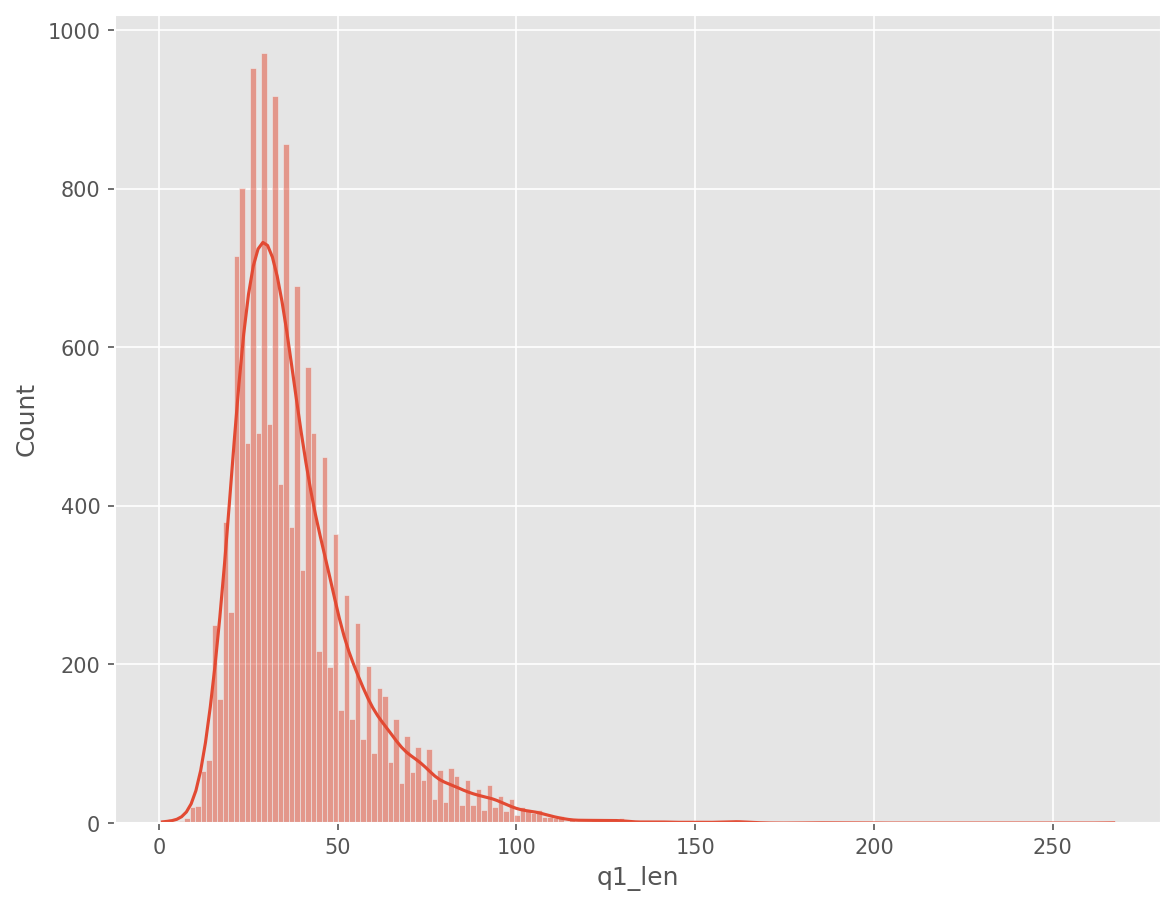

In [15]:
print('q1: ____________________')
print('\t\t\tminimum characters',df['q1_len'].min())
print('\t\t\tmaximum characters',df['q1_len'].max())
print('\t\t\taverage num of characters',int(df['q1_len'].mean()))
plt.style.use("ggplot")

plt.figure(figsize=(9, 7), dpi=150)
sns.histplot(df['q1_len'], kde=True)
plt.show()

q2:______________________
			minimum characters 4
			maximum characters 699
			average num of characters 39


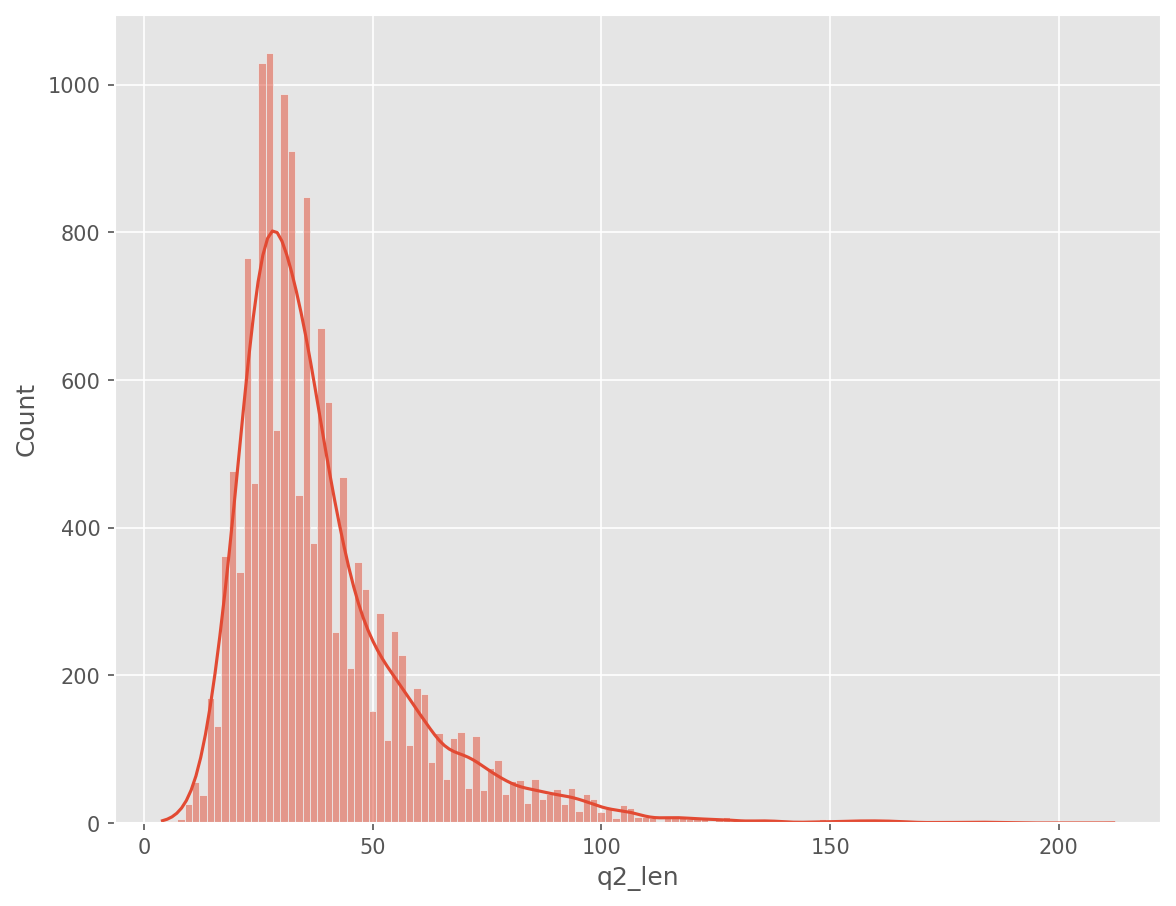

In [16]:
print('q2:______________________')
print('\t\t\tminimum characters',df['q2_len'].min())
print('\t\t\tmaximum characters',df['q2_len'].max())
print('\t\t\taverage num of characters',int(df['q2_len'].mean()))
plt.style.use("ggplot")

plt.figure(figsize=(9, 7), dpi=150)
sns.histplot(df[df['q2_len']<600]['q2_len'], kde=True)
plt.show()

#### 2. Distribution of the Number of Words

minimum words 1
maximum words 47
average num of words 6


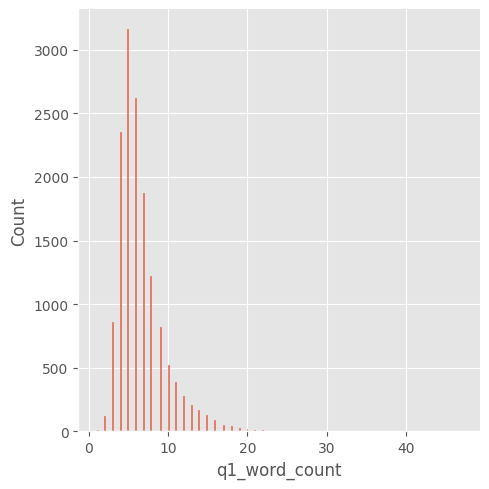

In [17]:
sns.displot(df['q1_word_count'])
print('minimum words',df['q1_word_count'].min())
print('maximum words',df['q1_word_count'].max())
print('average num of words',int(df['q1_word_count'].mean()))

minimum words 1
maximum words 125
average num of words 6


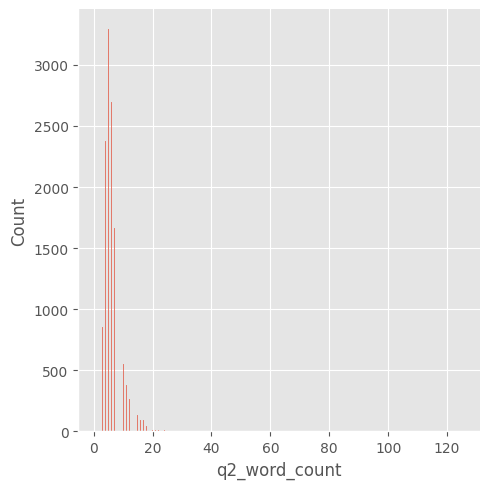

In [18]:
sns.displot(df[df['q2_word_count']<200]['q2_word_count'])
print('minimum words',df['q2_word_count'].min())
print('maximum words',df['q2_word_count'].max())
print('average num of words',int(df['q2_word_count'].mean()))

#### 3. Common Word Distribution

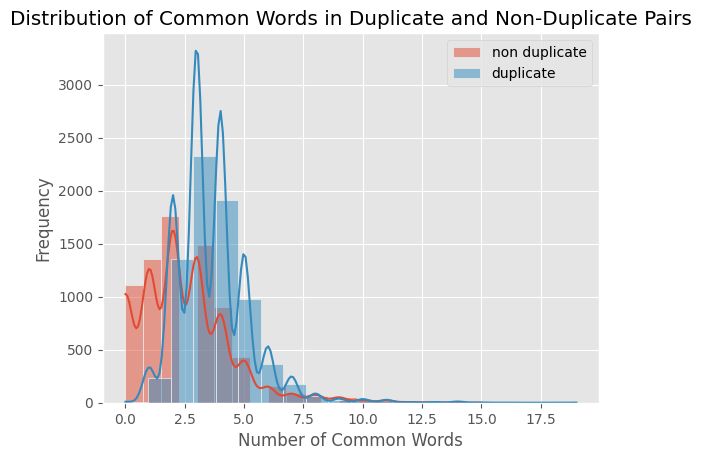

In [19]:
sns.histplot(df[df['is_duplicate'] == 0]['common_word_count'], label='non duplicate', kde=True, bins=20)
sns.histplot(df[df['is_duplicate'] == 1]['common_word_count'], label='duplicate', kde=True, bins=20)

plt.xlabel('Number of Common Words')
plt.ylabel('Frequency')
plt.title('Distribution of Common Words in Duplicate and Non-Duplicate Pairs')

plt.legend()

plt.show()

From the graph, we see that the probability that it will be a duplicate question is more
if the number of common words exceeds 4

#### 4. Total Word Analysis

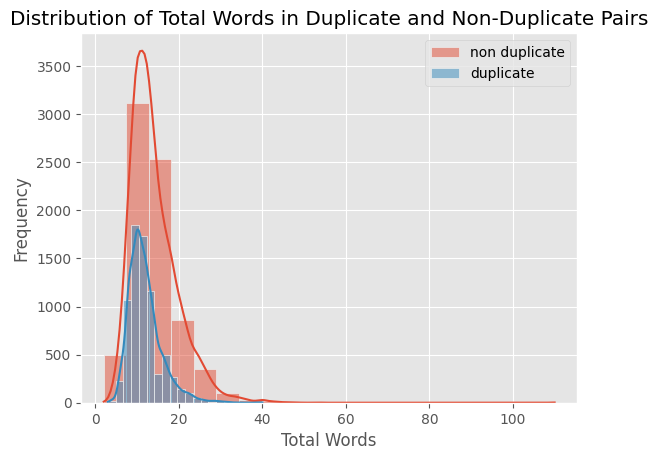

In [20]:
sns.histplot(df[df['is_duplicate'] == 0]['word_total'], label='non duplicate', kde=True, bins=20)
sns.histplot(df[df['is_duplicate'] == 1]['word_total'], label='duplicate', kde=True, bins=20)

plt.xlabel('Total Words')
plt.ylabel('Frequency')
plt.title('Distribution of Total Words in Duplicate and Non-Duplicate Pairs')

plt.legend()

plt.show()

Records are duplicated when the word count is between 0 and 20.
For counts exceeding 40, the model strongly prioritizes non-duplicates.

#### 5. Word Shared Analysis

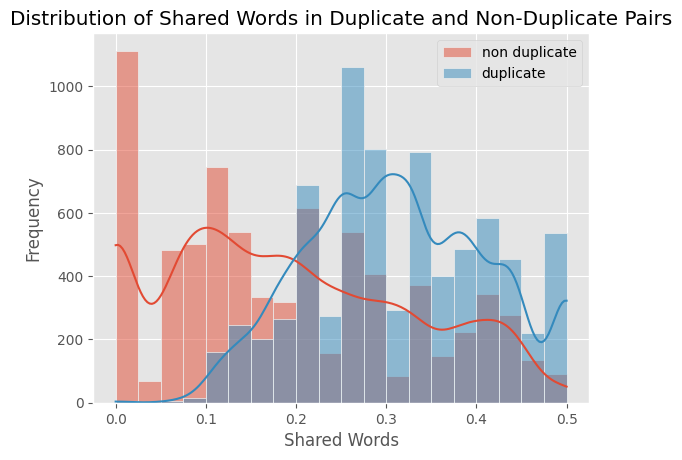

In [21]:
sns.histplot(df[df['is_duplicate'] == 0]['word_shared'], label='non duplicate', kde=True, bins=20)
sns.histplot(df[df['is_duplicate'] == 1]['word_shared'], label='duplicate', kde=True, bins=20)

plt.xlabel('Shared Words')
plt.ylabel('Frequency')
plt.title('Distribution of Shared Words in Duplicate and Non-Duplicate Pairs')

plt.legend()

plt.show()

Non-duplicates are probable when the words' share value is below 0.2.
However, duplication is expected if the word's share value surpasses 0.2.

# Machine Learning Model

#### 1. Separate the Independent and Dependent features

In [22]:
ques_df=df[['question1','question2']]
ques_df.head()

,question1,question2
5,astrology: i capricorn sun cap moon cap rising...,"i tripl capricorn (sun, moon ascend capricorn)..."
7,how i good geologist?,what i great geologist?
11,how i read find youtub comments?,how i see youtub comments?
12,what make physic easi learn?,how make physic easi learn?
13,what first sexual experi like?,what first sexual experience?


In [23]:
final_df=df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(15000, 8)


,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,word_total,word_shared
5,1,61,59,10,10,5,19,0.26
7,1,21,23,4,4,2,8,0.25
11,1,32,26,6,5,4,11,0.36
12,1,28,27,5,5,4,10,0.40
13,1,30,29,5,4,3,9,0.33


#### 2. Vectorizing the Feature

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

temp1=pd.DataFrame(q1_arr,index=ques_df.index)
temp2=pd.DataFrame(q2_arr,index=ques_df.index)

temp=pd.concat([temp1,temp2],axis=1)

temp.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from sklearn.preprocessing import MinMaxScaler
features_to_scale = final_df.columns[1:]
scaler = MinMaxScaler()
final_df[features_to_scale] = scaler.fit_transform(final_df[features_to_scale])
final_df.head()

,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,word_total,word_shared
5,1,0.225564,0.079137,0.195652,0.072581,0.263158,0.157407,0.52
7,1,0.075188,0.027338,0.065217,0.024194,0.105263,0.055556,0.50
11,1,0.116541,0.031655,0.108696,0.032258,0.210526,0.083333,0.72
12,1,0.101504,0.033094,0.086957,0.032258,0.210526,0.074074,0.80
13,1,0.109023,0.035971,0.086957,0.024194,0.157895,0.064815,0.66


In [26]:
final_df=pd.concat([final_df,temp],axis=1)
print(final_df.shape)
final_df.head()

(15000, 6008)


,is_duplicate,q1_len,q2_len,q1_word_count,q2_word_count,common_word_count,word_total,word_shared,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
5,1,0.225564,0.079137,0.195652,0.072581,0.263158,0.157407,0.52,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0.075188,0.027338,0.065217,0.024194,0.105263,0.055556,0.50,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,0.116541,0.031655,0.108696,0.032258,0.210526,0.083333,0.72,0,0,...,0,0,0,0,0,1,0,0,0,0
12,1,0.101504,0.033094,0.086957,0.032258,0.210526,0.074074,0.80,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,0.109023,0.035971,0.086957,0.024194,0.157895,0.064815,0.66,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3. Train-Test-Split

In [27]:
X = final_df.iloc[:,1:].values
y = final_df.iloc[:,0].values

In [28]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test,y_pred_test))

#### OVERFITTING !!!!

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [1, 2, 4],
# }

# grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# best_clf = grid_search.best_estimator_
# print("Best Parameters:", best_params)
# y_pred_test_tuned = best_clf.predict(X_test)
# accuracy_tuned = accuracy_score(y_test, y_pred_test_tuned)
# print("Accuracy after tuning:", accuracy_tuned)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

In [33]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test,y_pred_test))

0.8241666666666667
0.7563333333333333


In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_y_pred_train = dtc.predict(X_train)
dtc_y_pred_test = dtc.predict(X_test)

In [45]:
print(accuracy_score(dtc_y_pred_train, y_train))
print(accuracy_score(dtc_y_pred_test, y_test))

0.9996666666666667
0.7126666666666667


In [42]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
abc_y_pred_train = abc.predict(X_train)
abc_y_pred_test = abc.predict(X_test)

In [43]:
print(accuracy_score(abc_y_pred_train, y_train))
print(accuracy_score(abc_y_pred_test, y_test))

0.7413333333333333
0.7286666666666667
